# Part 3: Models

# Import Necessary Libraries

In [66]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Directory

In [67]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [68]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [69]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  693
[Train] Number of NOCORROSION Images:  580
[Train] Number of TOTAL Images:  1273


In [70]:
val_CORROSION_num = num_files_in_direcotry(validation_CORROSION_dir)
val_NOCORROSION_num = num_files_in_direcotry(validation_NOCORROSION_dir)
val_SUM_num = val_CORROSION_num + val_NOCORROSION_num

print("[Validation] Number of CORROSION Images: ", val_CORROSION_num)
print("[Validation] Number of NOCORROSION Images: ", val_NOCORROSION_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of CORROSION Images:  198
[Validation] Number of NOCORROSION Images:  166
[Validation] Number of TOTAL Images:  364


In [71]:
test_CORROSION_num = num_files_in_direcotry(test_CORROSION_dir)
test_NOCORROSION_num = num_files_in_direcotry(test_NOCORROSION_dir)
test_SUM_num = test_CORROSION_num + test_NOCORROSION_num

print("[Test] Number of CORROSION Images: ", test_CORROSION_num)
print("[Test] Number of NOCORROSION Images: ", test_NOCORROSION_num)
print("[Test] Number of TOTAL Images: ", test_SUM_num)

[Test] Number of CORROSION Images:  99
[Test] Number of NOCORROSION Images:  83
[Test] Number of TOTAL Images:  182


# Function for results visualization

In [72]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [73]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [9]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


# Model 1: Baseline Model

In [10]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    

    cnn.add(Flatten())

    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [11]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
40/40 [==============================] - 23s 576ms/step - loss: 0.6942 - acc: 0.5217 - val_loss: 0.6559 - val_acc: 0.7253
Epoch 2/20
40/40 [==============================] - 22s 544ms/step - loss: 0.6379 - acc: 0.7001 - val_loss: 0.5824 - val_acc: 0.7363
Epoch 3/20
40/40 [==============================] - 22s 543ms/step - loss: 0.5476 - acc: 0.7330 - val_loss: 0.5701 - val_acc: 0.7555
Epoch 4/20
40/40 [==============================] - 22s 549ms/step - loss: 0.5600 - acc: 0.7358 - val_loss: 0.5579 - val_acc: 0.7665
Epoch 5/20
40/40 [==============================] - 22s 537ms/step - loss: 0.4869 - acc: 0.7697 - val_loss: 0.5314 - val_acc: 0.7555
Epoch 6/20
40/40 [==============================] - 22s 556ms/step - loss: 0.4514 - acc: 0.8023 - val_loss: 0.6510 - val_acc: 0.7170
Epoch 7/20
40/40 [==============================] - 22s 541ms/step - loss: 0.4651 - acc: 0.8140 - val_loss: 0.4917 - val_acc: 0.7775
Epoch 8/20
40/40 [==============================] - 22s 548ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 85.16% | Precision = 78.57% | Recall = 92.77% | Specificity = 78.79% | F1 Score = 85.08%


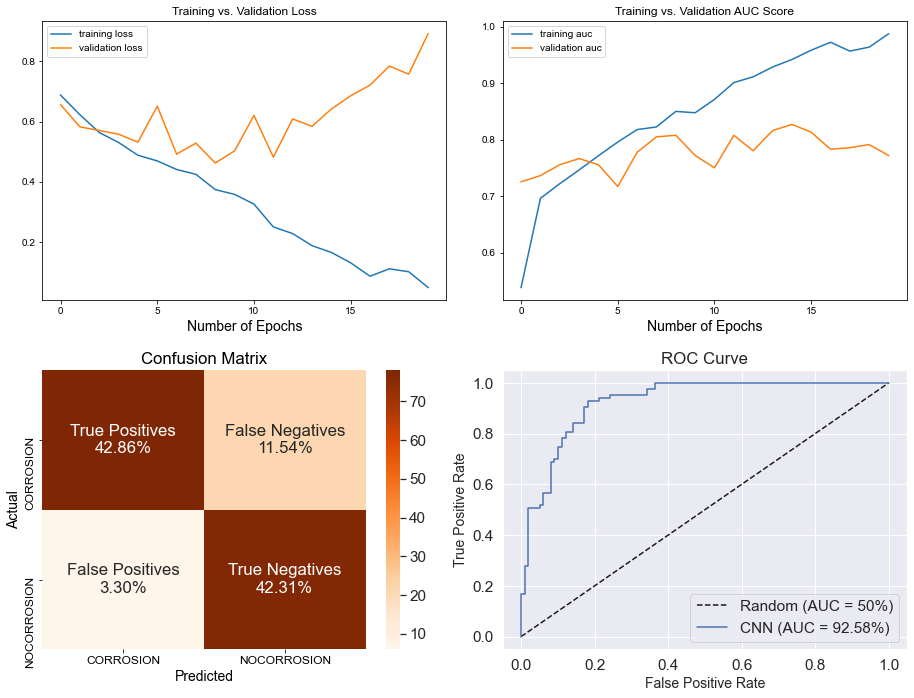

In [12]:
create_charts(cnn,cnn_model)

In the beginning, the validation loss goes down. But at epoch 7 this stops and the validation loss starts increasing rapidly. This is when the model begins to be overfitting. The training loss continues to go down and almost reaches zero at epoch 20. This is normal as the model is trained to fit the train data as good as possible.

Now, we need to do something about the overfitting. There are different options to do that:
- Data augmentation: data augmentation is an excellent practice to add more data to the existing dataset and add minor alterations and diversity to avoid the model from overfitting to training data.
- l1&l2 regulations: apply regulation, which comes down to adding a cost to the loss function for large weights.
- Dropout layers: use dropout layers, which will randomly remove certain features by setting them to zero.
- Batch normalization: normalize the input layer by adjusting and scaling the activations. 

# Model 2: Data Augmentation, Epoch = 30

In [74]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [14]:
cnn_model = cnn.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
40/40 [==============================] - 24s 602ms/step - loss: 0.5132 - acc: 0.8154 - val_loss: 0.4041 - val_acc: 0.8187
Epoch 2/30
40/40 [==============================] - 24s 596ms/step - loss: 0.4215 - acc: 0.8327 - val_loss: 0.6016 - val_acc: 0.7637
Epoch 3/30
40/40 [==============================] - 24s 586ms/step - loss: 0.3861 - acc: 0.8390 - val_loss: 0.6712 - val_acc: 0.7500
Epoch 4/30
40/40 [==============================] - 24s 590ms/step - loss: 0.3924 - acc: 0.8429 - val_loss: 0.4249 - val_acc: 0.8132
Epoch 5/30
40/40 [==============================] - 24s 598ms/step - loss: 0.3484 - acc: 0.8539 - val_loss: 0.4220 - val_acc: 0.7995
Epoch 6/30
40/40 [==============================] - 24s 577ms/step - loss: 0.3545 - acc: 0.8562 - val_loss: 0.4227 - val_acc: 0.8132
Epoch 7/30
40/40 [==============================] - 24s 602ms/step - loss: 0.3658 - acc: 0.8610 - val_loss: 0.5194 - val_acc: 0.7308
Epoch 8/30
40/40 [==============================] - 25s 625ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 90.11% | Precision = 85.71% | Recall = 93.98% | Specificity = 86.87% | F1 Score = 89.66%


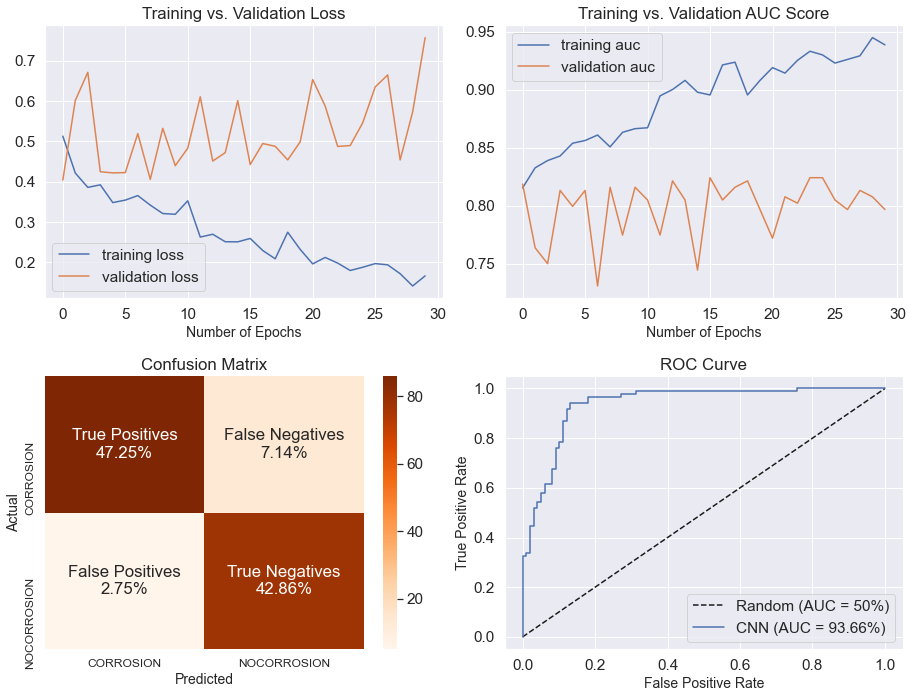

In [15]:
create_charts(cnn,cnn_model)

From training vs validation loss curves, it can be seen that the training model still have overfitting issues.

# Model3; Reduce model complexity, Epoch = 30

In [ ]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

In [18]:
 # Design the model
    
def build_model_3():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_3 = build_model_3()

In [19]:
cnn_model_3 = cnn_3.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

Epoch 1/30
40/40 [==============================] - 23s 577ms/step - loss: 0.7072 - acc: 0.5321 - val_loss: 0.6732 - val_acc: 0.5165
Epoch 2/30
40/40 [==============================] - 23s 566ms/step - loss: 0.6680 - acc: 0.5980 - val_loss: 0.5886 - val_acc: 0.7088
Epoch 3/30
40/40 [==============================] - 23s 562ms/step - loss: 0.5772 - acc: 0.7114 - val_loss: 0.5976 - val_acc: 0.7060
Epoch 4/30
40/40 [==============================] - 22s 546ms/step - loss: 0.5852 - acc: 0.6885 - val_loss: 0.5165 - val_acc: 0.7720
Epoch 5/30
40/40 [==============================] - 22s 552ms/step - loss: 0.5143 - acc: 0.7558 - val_loss: 0.5168 - val_acc: 0.7720
Epoch 6/30
40/40 [==============================] - 22s 550ms/step - loss: 0.4994 - acc: 0.7695 - val_loss: 0.5003 - val_acc: 0.7637
Epoch 7/30
40/40 [==============================] - 22s 545ms/step - loss: 0.4873 - acc: 0.7737 - val_loss: 0.4802 - val_acc: 0.7802
Epoch 8/30
40/40 [==============================] - 22s 554ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 84.07% | Precision = 81.40% | Recall = 84.34% | Specificity = 83.84% | F1 Score = 82.84%


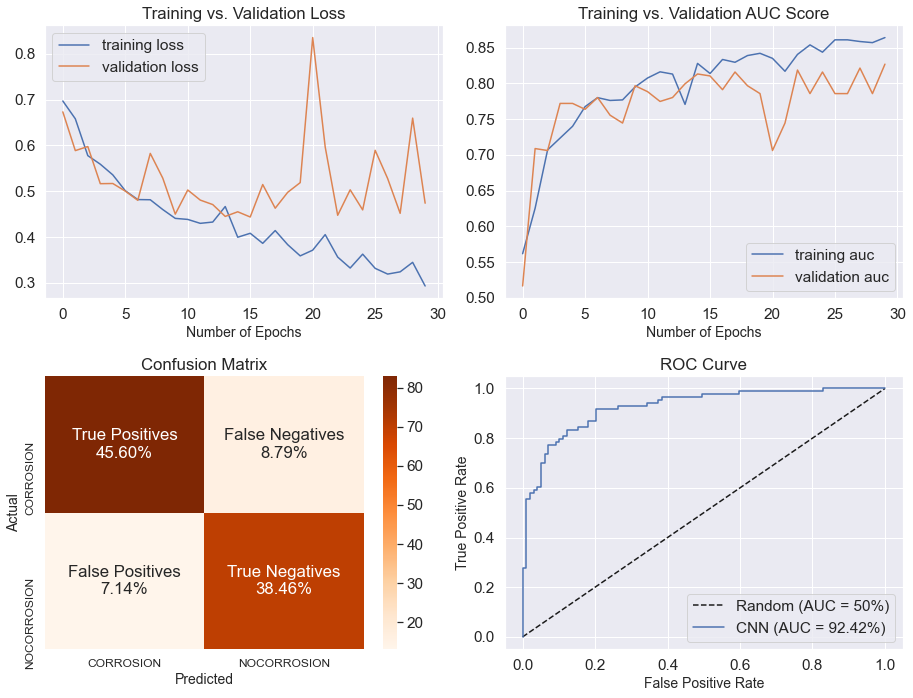

In [20]:
create_charts(cnn_3,cnn_model_3)

# Model4: Dropout = 0.1, Epoch = 30

In [23]:
 # Design the model
    
def build_model_4():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_4 = build_model_4()

In [24]:
cnn_model_4 = cnn_4.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

Epoch 1/30
40/40 [==============================] - 23s 574ms/step - loss: 0.7079 - acc: 0.4762 - val_loss: 0.6715 - val_acc: 0.5577
Epoch 2/30
40/40 [==============================] - 23s 564ms/step - loss: 0.6788 - acc: 0.5695 - val_loss: 0.5713 - val_acc: 0.7500
Epoch 3/30
40/40 [==============================] - 23s 566ms/step - loss: 0.5801 - acc: 0.7084 - val_loss: 0.5560 - val_acc: 0.7253
Epoch 4/30
40/40 [==============================] - 23s 558ms/step - loss: 0.5513 - acc: 0.7442 - val_loss: 0.5800 - val_acc: 0.7225
Epoch 5/30
40/40 [==============================] - 23s 565ms/step - loss: 0.5276 - acc: 0.7412 - val_loss: 0.5223 - val_acc: 0.7802
Epoch 6/30
40/40 [==============================] - 23s 560ms/step - loss: 0.5296 - acc: 0.7298 - val_loss: 0.5499 - val_acc: 0.7335
Epoch 7/30
40/40 [==============================] - 23s 561ms/step - loss: 0.5372 - acc: 0.7398 - val_loss: 0.5060 - val_acc: 0.7857
Epoch 8/30
40/40 [==============================] - 23s 564ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 83.52% | Precision = 79.78% | Recall = 85.54% | Specificity = 81.82% | F1 Score = 82.56%


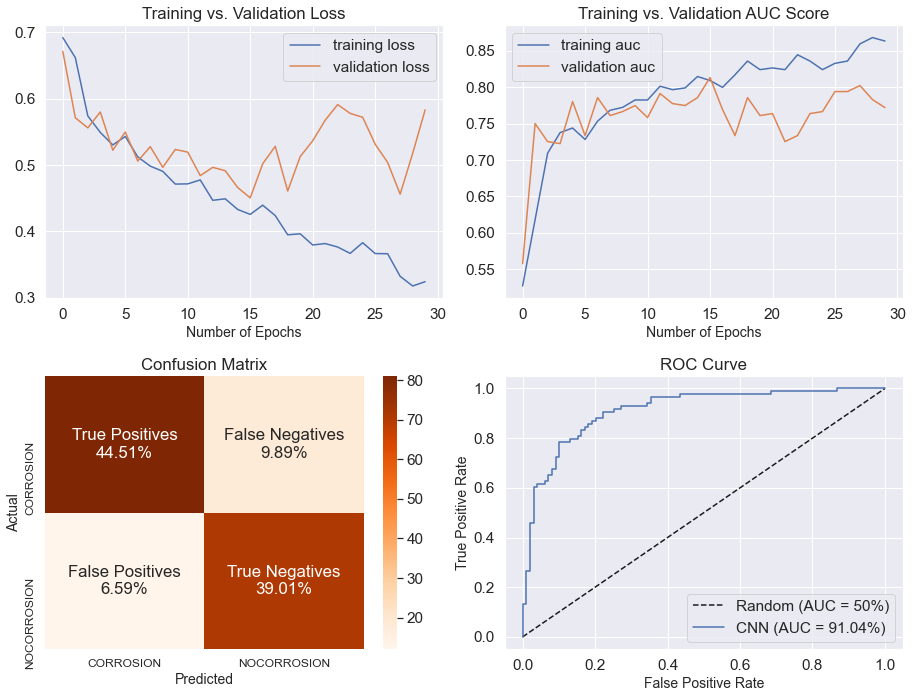

In [25]:
create_charts(cnn_4,cnn_model_4)

# Model5: Dropout = 0.1, Dropout = 0.2, Dropout = 0.25, Dense = 128, Epoch = 100, Early Stopping 

In [86]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [87]:
 # Design the model
    
def build_model_5():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_5 = build_model_5()

In [88]:
cnn_model_5 = cnn_5.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 25s 617ms/step - loss: 0.6936 - acc: 0.5696 - val_loss: 0.6587 - val_acc: 0.5879
Epoch 2/100
40/40 [==============================] - 25s 616ms/step - loss: 0.6530 - acc: 0.6480 - val_loss: 0.5757 - val_acc: 0.7198
Epoch 3/100
40/40 [==============================] - 25s 628ms/step - loss: 0.5676 - acc: 0.7286 - val_loss: 0.6408 - val_acc: 0.7500
Epoch 4/100
40/40 [==============================] - 25s 635ms/step - loss: 0.5821 - acc: 0.7511 - val_loss: 0.5135 - val_acc: 0.7500
Epoch 5/100
40/40 [==============================] - 25s 634ms/step - loss: 0.5333 - acc: 0.7381 - val_loss: 0.5424 - val_acc: 0.7390
Epoch 6/100
40/40 [==============================] - 25s 642ms/step - loss: 0.5376 - acc: 0.7445 - val_loss: 0.5921 - val_acc: 0.7308
Epoch 7/100
40/40 [==============================] - 25s 636ms/step - loss: 0.4852 - acc: 0.7721 - val_loss: 0.5167 - val_acc: 0.7720
Epoch 8/100
40/40 [==============================] - 25s 636ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 84.62% | Precision = 84.47% | Recall = 87.88% | Specificity = 80.72% | F1 Score = 86.14%


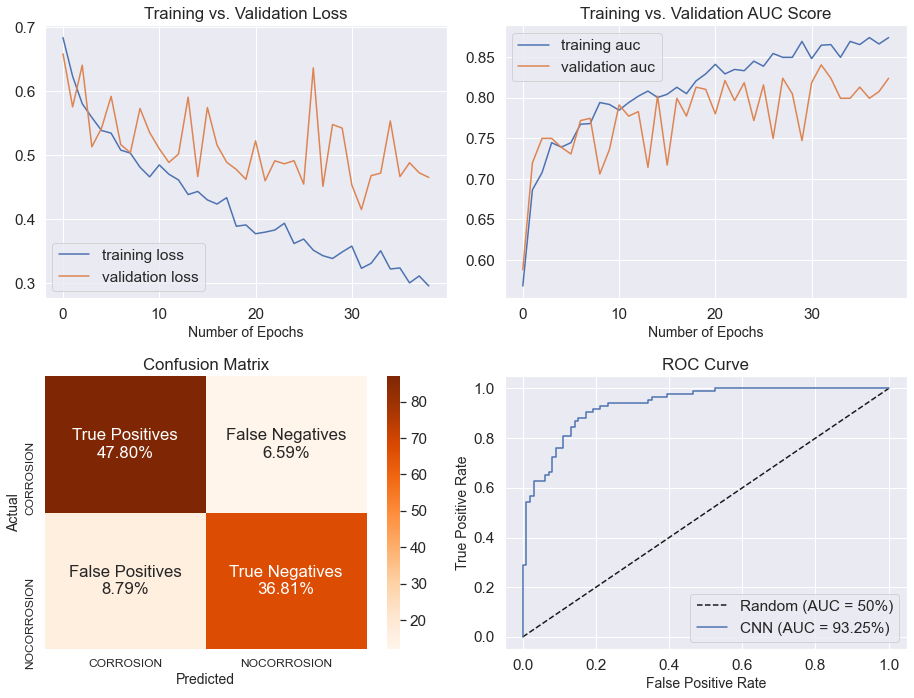

In [89]:
create_charts(cnn_5,cnn_model_5)

# Model6: Dropout = 0.1, Dropout = 0.2, Dropout = 0.2, Dropout =0.2, Dense layers = 128, Doptout = 0.2,Epoch = 100, Early Stopping

In [90]:
 # Design the model
    
def build_model_6():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_6 = build_model_6()

In [91]:
cnn_model_6 = cnn_6.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 29s 715ms/step - loss: 0.7078 - acc: 0.5166 - val_loss: 0.6435 - val_acc: 0.6374
Epoch 2/100
40/40 [==============================] - 28s 688ms/step - loss: 0.6599 - acc: 0.5931 - val_loss: 0.6642 - val_acc: 0.5934
Epoch 3/100
40/40 [==============================] - 28s 694ms/step - loss: 0.6273 - acc: 0.6474 - val_loss: 0.5893 - val_acc: 0.7253
Epoch 4/100
40/40 [==============================] - 27s 675ms/step - loss: 0.6069 - acc: 0.7169 - val_loss: 0.5651 - val_acc: 0.7582
Epoch 5/100
40/40 [==============================] - 28s 697ms/step - loss: 0.5612 - acc: 0.7338 - val_loss: 0.6184 - val_acc: 0.6566
Epoch 6/100
40/40 [==============================] - 28s 690ms/step - loss: 0.5722 - acc: 0.7231 - val_loss: 0.5799 - val_acc: 0.7253
Epoch 7/100
40/40 [==============================] - 28s 678ms/step - loss: 0.5349 - acc: 0.7409 - val_loss: 0.5445 - val_acc: 0.7610
Epoch 8/100
40/40 [==============================] - 30s 755ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 81.87% | Precision = 92.31% | Recall = 72.73% | Specificity = 92.77% | F1 Score = 81.36%


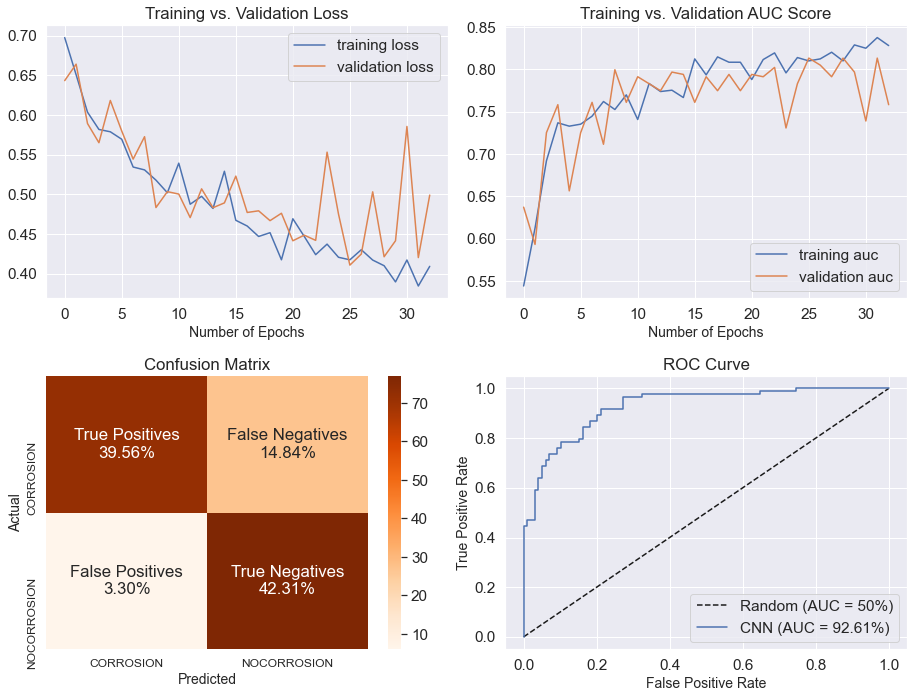

In [93]:
create_charts(cnn_6,cnn_model_6)

# Model7: Dropout = 0.1, Dropout = 0.2, Dropout = 0.2, Dropout =0.2, Dense layer = 128, Epoch = 100, Early Stopping

In [94]:
 # Design the model
    
def build_model_7():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_7 = build_model_7()

In [95]:
cnn_model_7 = cnn_7.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 29s 712ms/step - loss: 0.7040 - acc: 0.4983 - val_loss: 0.6657 - val_acc: 0.6868
Epoch 2/100
40/40 [==============================] - 28s 689ms/step - loss: 0.6558 - acc: 0.6228 - val_loss: 0.6142 - val_acc: 0.6813
Epoch 3/100
40/40 [==============================] - 28s 696ms/step - loss: 0.5992 - acc: 0.7123 - val_loss: 0.6330 - val_acc: 0.6484
Epoch 4/100
40/40 [==============================] - 28s 687ms/step - loss: 0.5974 - acc: 0.6804 - val_loss: 0.5440 - val_acc: 0.7390
Epoch 5/100
40/40 [==============================] - 28s 667ms/step - loss: 0.5324 - acc: 0.7567 - val_loss: 0.5208 - val_acc: 0.7582
Epoch 6/100
40/40 [==============================] - 28s 698ms/step - loss: 0.5339 - acc: 0.7446 - val_loss: 0.5746 - val_acc: 0.7500
Epoch 7/100
40/40 [==============================] - 28s 679ms/step - loss: 0.5658 - acc: 0.7030 - val_loss: 0.4948 - val_acc: 0.7857
Epoch 8/100
40/40 [==============================] - 26s 662ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 85.71% | Precision = 89.25% | Recall = 83.84% | Specificity = 87.95% | F1 Score = 86.46%


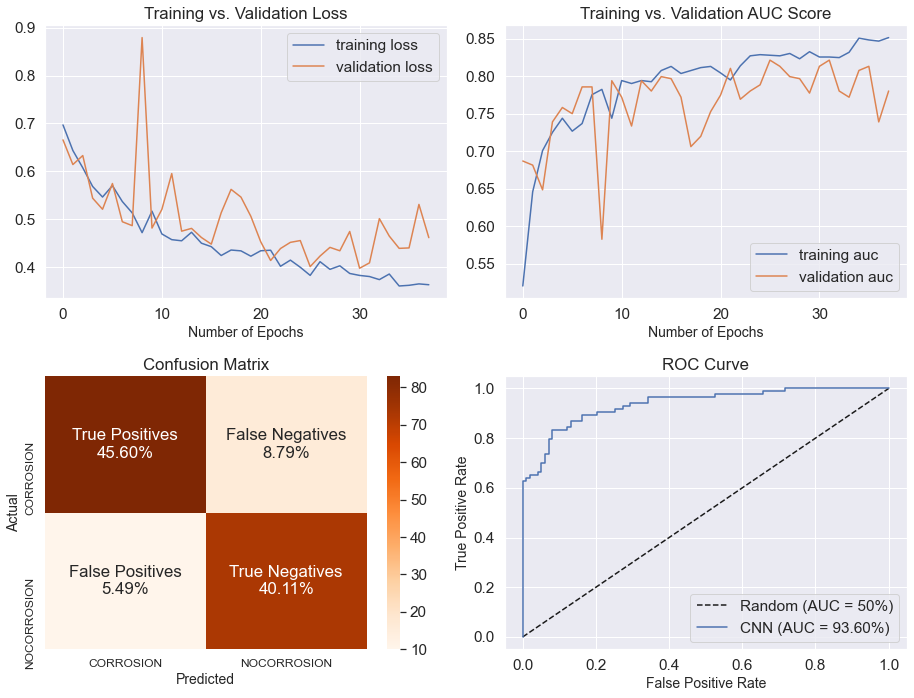

In [96]:
create_charts(cnn_7,cnn_model_7)

# Model8:Dropout = 0.1, Dropout = 0.2, Dropout = 0.2, Dropout =0.2, Dense layer = 256, Epoch = 100, Early Stopping

In [97]:
 # Design the model
    
def build_model_8():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_8 = build_model_8()

In [98]:
cnn_model_8 = cnn_8.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 26s 646ms/step - loss: 0.7106 - acc: 0.4958 - val_loss: 0.6945 - val_acc: 0.5440
Epoch 2/100
40/40 [==============================] - 26s 640ms/step - loss: 0.6899 - acc: 0.5694 - val_loss: 0.6319 - val_acc: 0.6923
Epoch 3/100
40/40 [==============================] - 25s 628ms/step - loss: 0.5880 - acc: 0.7208 - val_loss: 0.5889 - val_acc: 0.7033
Epoch 4/100
40/40 [==============================] - 25s 633ms/step - loss: 0.5568 - acc: 0.7276 - val_loss: 0.5764 - val_acc: 0.7143
Epoch 5/100
40/40 [==============================] - 25s 631ms/step - loss: 0.5456 - acc: 0.7389 - val_loss: 0.5992 - val_acc: 0.6923
Epoch 6/100
40/40 [==============================] - 25s 633ms/step - loss: 0.5503 - acc: 0.7328 - val_loss: 0.6145 - val_acc: 0.7692
Epoch 7/100
40/40 [==============================] - 25s 627ms/step - loss: 0.5646 - acc: 0.7544 - val_loss: 0.5218 - val_acc: 0.7775
Epoch 8/100
40/40 [==============================] - 25s 621ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 80.22% | Precision = 85.39% | Recall = 76.77% | Specificity = 84.34% | F1 Score = 80.85%


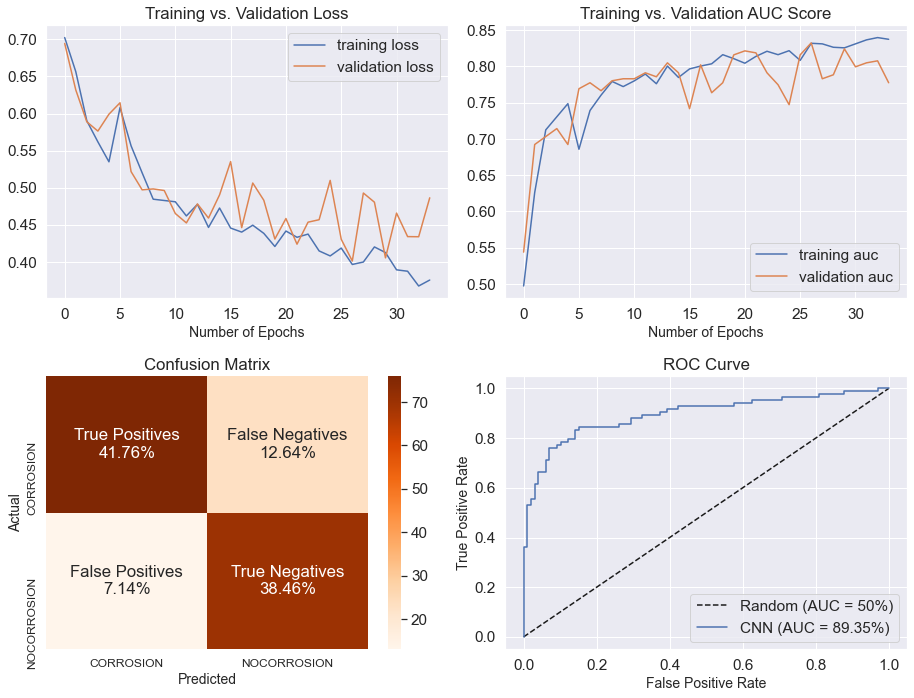

In [99]:
create_charts(cnn_8,cnn_model_8)

# Model 9:Dropout = 0.1, Dropout = 0.2, Dropout = 0.2, Dropout =0.2, Dense layer = 256, Dropout = 0.1, Epoch = 100, Early Stopping

In [106]:
 # Design the model
    
def build_model_9():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(16, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_9 = build_model_9()

In [107]:
cnn_model_9 = cnn_9.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 28s 700ms/step - loss: 0.6953 - acc: 0.5624 - val_loss: 0.6498 - val_acc: 0.6676
Epoch 2/100
40/40 [==============================] - 28s 688ms/step - loss: 0.6381 - acc: 0.6650 - val_loss: 0.5818 - val_acc: 0.7308
Epoch 3/100
40/40 [==============================] - 28s 692ms/step - loss: 0.5844 - acc: 0.7069 - val_loss: 0.5482 - val_acc: 0.7555
Epoch 4/100
40/40 [==============================] - 28s 673ms/step - loss: 0.5669 - acc: 0.7359 - val_loss: 0.5450 - val_acc: 0.7527
Epoch 5/100
40/40 [==============================] - 28s 696ms/step - loss: 0.5263 - acc: 0.7437 - val_loss: 0.5289 - val_acc: 0.7692
Epoch 6/100
40/40 [==============================] - 28s 681ms/step - loss: 0.4777 - acc: 0.7844 - val_loss: 0.5023 - val_acc: 0.7582
Epoch 7/100
40/40 [==============================] - 27s 674ms/step - loss: 0.5238 - acc: 0.7620 - val_loss: 0.4861 - val_acc: 0.7885
Epoch 8/100
40/40 [==============================] - 28s 685ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 84.07% | Precision = 92.68% | Recall = 76.77% | Specificity = 92.77% | F1 Score = 83.98%


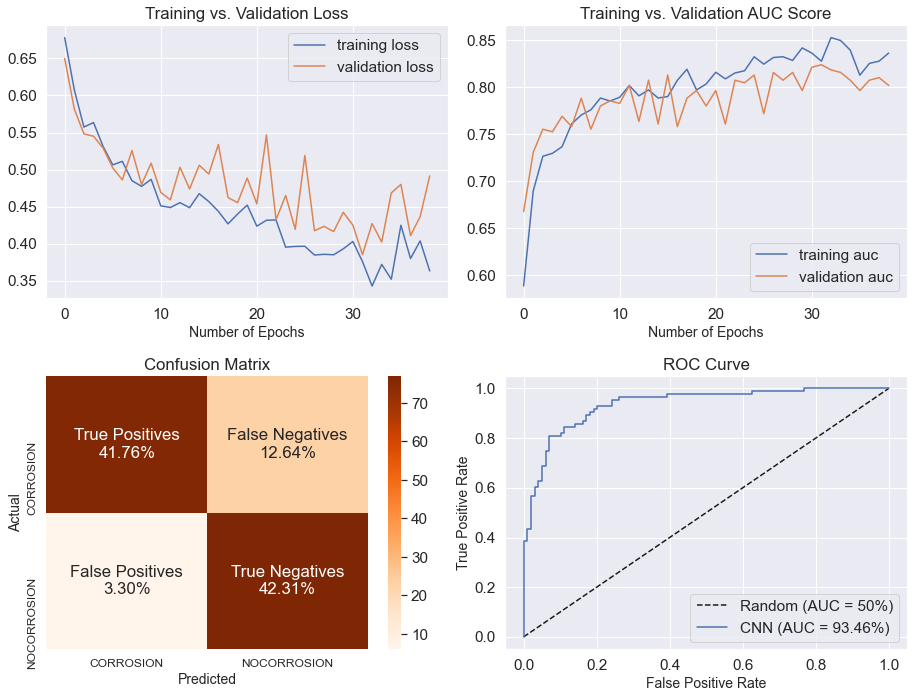

In [108]:
create_charts(cnn_9,cnn_model_9)